# Análise Exploratória de Dados (EDA) - Camada Raw/Bronze

## 📊 Introdução e Objetivos

Este notebook realiza uma **análise exploratória completa (EDA)** dos dados brutos na camada **Raw/Bronze** do pipeline de dados. O objetivo principal é compreender profundamente os dados antes de qualquer transformação ou modelagem.

### 🎯 Objetivos Principais

- **Compreender a estrutura e qualidade dos dados** antes de qualquer transformação
- **Identificar padrões, correlações e anomalias** nos dados
- **Detectar outliers e problemas de qualidade** que precisam ser tratados nas próximas camadas
- **Gerar insights preliminares** que orientarão o design da camada Silver/Gold
- **Documentar limitações e características** do dataset para referência futura

### 📋 Sobre o Dataset

Este dataset contém dados brutos sobre voos e atrasos de companhias aéreas. Os dados são coletados na camada Raw/Bronze e representam informações não processadas que serão transformadas nas camadas subsequentes (Silver e Gold).

**Nota**: O código deste notebook detecta automaticamente as colunas numéricas e categóricas, sem assumir nomes específicos de colunas. Isso garante que a análise seja genérica e reutilizável.

### 🔍 Escopo da Análise

Esta análise é **puramente exploratória** e não realiza:
- ❌ Conexões com bancos de dados
- ❌ Transformações de dados (isso será feito na camada Silver)
- ❌ Limpezas definitivas (apenas identificação de problemas)

### 📐 Metodologia

A análise seguirá uma abordagem sistemática e reprodutível:

1. **Visão geral do dataset**: estrutura, tipos, dimensões
2. **Avaliação de qualidade**: nulos, duplicados, cardinalidade
3. **Estatísticas descritivas**: medidas de tendência central e dispersão
4. **Análise de distribuições**: histogramas e boxplots para variáveis numéricas
5. **Análise de correlações**: heatmap de correlação entre variáveis numéricas
6. **Análise categórica**: gráfico de pizza para variável categórica mais relevante
7. **Regressão linear exploratória**: relação entre variáveis numéricas
8. **Detecção de outliers**: método IQR (Intervalo Interquartil) com visualizações
9. **Síntese de insights**: principais achados e limitações
10. **Perguntas analíticas**: orientações para o design da camada Silver/Gold

### ⚙️ Configurações de Reprodutibilidade

- Warnings suprimidos para outputs mais limpos
- Estilo de gráficos padronizado (seaborn-v0_8)
- Seed fixo para amostragens (quando aplicável)
- Funções utilitárias reutilizáveis


In [7]:
# Configuração inicial
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Tentar importar statsmodels, caso contrário usar sklearn
try:
    import statsmodels.api as sm
    from statsmodels.regression.linear_model import OLS
    USE_STATSMODELS = True
except ImportError:
    from sklearn.linear_model import LinearRegression
    USE_STATSMODELS = False
    print("statsmodels não disponível, usando sklearn.linear_model.LinearRegression")

# Configuração de estilo
try:
    plt.style.use("seaborn-v0_8")
except OSError:
    try:
        plt.style.use("seaborn")
    except OSError:
        plt.style.use("default")
        print("Estilo seaborn não disponível, usando estilo padrão")

# Configuração de visualização
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Bibliotecas carregadas com sucesso!")


Bibliotecas carregadas com sucesso!


## 📂 Carregamento do Dataset

Nesta seção, carregamos o arquivo CSV bruto que contém os dados na camada Raw/Bronze.

### 🔄 Estratégia de Carregamento

O código implementa uma estratégia robusta de carregamento que tenta encontrar o arquivo em diferentes localizações:

1. **Primeiro**: Tenta carregar `dados_brutos.csv` no diretório atual
2. **Segundo**: Tenta carregar `data_raw.csv` no diretório atual
3. **Terceiro**: Tenta carregar `dados_brutos.csv` em `Data Layer/raw/`
4. **Quarto**: Tenta carregar `data_raw.csv` em `Data Layer/raw/`

Isso garante que o notebook funcione independentemente de onde seja executado.

### 📝 Observações

- O arquivo é carregado com `low_memory=False` para garantir detecção correta de tipos de dados
- O caminho do arquivo carregado é armazenado para uso posterior (salvamento de artefatos)
- Se nenhum arquivo for encontrado, uma exceção clara é lançada com instruções


In [8]:
# Definir caminhos possíveis (notebook pode ser executado de diferentes diretórios)
possible_base_paths = [
    Path("."),  # Diretório atual
    Path(".") / "Data Layer" / "raw",  # Caminho relativo a partir da raiz
]

# Tentar carregar o CSV
csv_files = ["dados_brutos.csv", "data_raw.csv"]
df = None
csv_file_used = None
csv_path_used = None

# Primeiro, tentar no diretório atual (caso o notebook esteja em Data Layer/raw/)
for csv_file in csv_files:
    csv_path = Path(".") / csv_file
    if csv_path.exists():
        print(f"Carregando: {csv_path}")
        try:
            df = pd.read_csv(csv_path, low_memory=False)
            csv_file_used = csv_file
            csv_path_used = csv_path
            print(f"✓ Arquivo carregado com sucesso: {csv_file}")
            break
        except Exception as e:
            print(f"Erro ao carregar {csv_file}: {e}")
            continue

# Se não encontrou, tentar no caminho Data Layer/raw/
if df is None:
    raw_path = Path(".") / "Data Layer" / "raw"
    for csv_file in csv_files:
        csv_path = raw_path / csv_file
        if csv_path.exists():
            print(f"Carregando: {csv_path}")
            try:
                df = pd.read_csv(csv_path, low_memory=False)
                csv_file_used = csv_file
                csv_path_used = csv_path
                print(f"✓ Arquivo carregado com sucesso: {csv_file}")
                break
            except Exception as e:
                print(f"Erro ao carregar {csv_file}: {e}")
                continue

if df is None:
    raise FileNotFoundError(
        f"Nenhum dos arquivos encontrado: {csv_files}. "
        f"Verifique se o arquivo existe no diretório atual ou em Data Layer/raw/"
    )

# Definir raw_path para uso posterior (onde salvar artefatos)
raw_path = csv_path_used.parent if csv_path_used else Path(".") / "Data Layer" / "raw"

print(f"\nDataset carregado: {csv_file_used}")
print(f"Dimensões: {df.shape[0]:,} linhas × {df.shape[1]} colunas")


Carregando: data_raw.csv
✓ Arquivo carregado com sucesso: data_raw.csv

Dataset carregado: data_raw.csv
Dimensões: 279,182 linhas × 22 colunas


## 👁️ Visão Geral do Dataset

Esta seção apresenta uma **visão geral completa** da estrutura do dataset, fornecendo uma primeira impressão dos dados.

### 📋 O que será analisado:

1. **Primeiras e últimas linhas**: Visualização das primeiras e últimas 5 linhas para entender o formato dos dados
2. **Informações sobre tipos**: Tipos de dados de cada coluna e uso de memória
3. **Lista de colunas**: Nomes completos de todas as colunas disponíveis

### 🔍 Principais Informações

- **Dimensões**: Número de linhas (observações) e colunas (variáveis)
- **Tipos de dados**: Identificação automática de colunas numéricas e categóricas
- **Memória**: Uso de memória do DataFrame em memória

### 💡 Interpretação

Esta visão geral nos permite:
- Verificar se os dados foram carregados corretamente
- Identificar rapidamente problemas óbvios (ex: colunas vazias, tipos incorretos)
- Entender a escala do dataset (pequeno, médio ou grande)
- Planejar análises subsequentes baseadas na estrutura observada


In [9]:
# Primeiras linhas
print("=" * 80)
print("PRIMEIRAS 5 LINHAS DO DATASET")
print("=" * 80)
display(df.head())

print("\n" + "=" * 80)
print("ÚLTIMAS 5 LINHAS DO DATASET")
print("=" * 80)
display(df.tail())


PRIMEIRAS 5 LINHAS DO DATASET


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,Unnamed: 21
0,2004,1,DL,Delta Air Lines Inc.,PBI,"West Palm Beach/Palm Beach, FL: Palm Beach Int...",650.0,126.0,21.06,6.44,...,45.92,4.0,0.0,5425.0,881.0,397.0,2016.0,15.0,2116.0,NaN
1,2004,1,DL,Delta Air Lines Inc.,PDX,"Portland, OR: Portland International",314.0,61.0,14.09,2.61,...,10.05,30.0,3.0,2801.0,478.0,239.0,1365.0,0.0,719.0,NaN
2,2004,1,DL,Delta Air Lines Inc.,PHL,"Philadelphia, PA: Philadelphia International",513.0,97.0,27.60,0.42,...,17.12,15.0,0.0,4261.0,1150.0,16.0,2286.0,0.0,809.0,NaN
3,2004,1,DL,Delta Air Lines Inc.,PHX,"Phoenix, AZ: Phoenix Sky Harbor International",334.0,78.0,20.14,2.02,...,16.45,3.0,1.0,3400.0,1159.0,166.0,1295.0,0.0,780.0,NaN
4,2004,1,DL,Delta Air Lines Inc.,PIT,"Pittsburgh, PA: Pittsburgh International",217.0,47.0,8.08,0.44,...,16.59,4.0,1.0,1737.0,350.0,28.0,522.0,0.0,837.0,NaN



ÚLTIMAS 5 LINHAS DO DATASET


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,Unnamed: 21
279177,2019,1,MQ,Envoy Air,RIC,"Richmond, VA: Richmond International",195.0,68.0,12.12,1.87,...,36.04,22.0,0.0,4138.0,603.0,196.0,780.0,0.0,2559.0,NaN
279178,2019,1,MQ,Envoy Air,ROA,"Roanoke, VA: Roanoke Blacksburg Regional Woodr...",52.0,14.0,2.74,0.69,...,8.11,2.0,1.0,726.0,323.0,31.0,112.0,0.0,260.0,NaN
279179,2019,1,MQ,Envoy Air,ROC,"Rochester, NY: Greater Rochester International",106.0,26.0,4.67,2.26,...,7.26,17.0,0.0,1259.0,313.0,99.0,484.0,0.0,363.0,NaN
279180,2019,1,MQ,Envoy Air,RST,"Rochester, MN: Rochester International",116.0,35.0,6.83,6.92,...,9.75,22.0,0.0,2307.0,474.0,633.0,523.0,0.0,677.0,NaN
279181,2019,1,MQ,Envoy Air,SAT,"San Antonio, TX: San Antonio International",26.0,4.0,1.16,0.64,...,0.29,5.0,0.0,120.0,50.0,14.0,41.0,0.0,15.0,NaN


In [10]:
# Informações sobre tipos e memória
print("=" * 80)
print("INFORMAÇÕES SOBRE TIPOS DE DADOS E MEMÓRIA")
print("=" * 80)
df.info()

print(f"\nMemória total utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


INFORMAÇÕES SOBRE TIPOS DE DADOS E MEMÓRIA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279182 entries, 0 to 279181
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 279182 non-null  int64  
 1    month               279182 non-null  int64  
 2   carrier              279182 non-null  object 
 3   carrier_name         279182 non-null  object 
 4   airport              279182 non-null  object 
 5   airport_name         279182 non-null  object 
 6   arr_flights          278806 non-null  float64
 7   arr_del15            278744 non-null  float64
 8   carrier_ct           278806 non-null  float64
 9    weather_ct          278806 non-null  float64
 10  nas_ct               278806 non-null  float64
 11  security_ct          278806 non-null  float64
 12  late_aircraft_ct     278806 non-null  float64
 13  arr_cancelled        278806 non-null  float64
 14  arr_diverted         2788

In [11]:
# Lista de colunas
print("=" * 80)
print(f"COLUNAS DO DATASET ({len(df.columns)} colunas)")
print("=" * 80)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


COLUNAS DO DATASET (22 colunas)
 1. year
 2.  month
 3. carrier
 4. carrier_name
 5. airport
 6. airport_name
 7. arr_flights
 8. arr_del15
 9. carrier_ct
10.  weather_ct
11. nas_ct
12. security_ct
13. late_aircraft_ct
14. arr_cancelled
15. arr_diverted
16.  arr_delay
17.  carrier_delay
18. weather_delay
19. nas_delay
20. security_delay
21. late_aircraft_delay
22. Unnamed: 21


## Qualidade dos Dados

Esta seção avalia a qualidade dos dados, identificando:
- **Valores nulos** por coluna (quantidade e percentual)
- **Linhas duplicadas** no dataset
- **Cardinalidade** de cada coluna (quantos valores únicos)
- **Tipos de dados** e possíveis inconsistências

### Limitações Identificadas

Durante esta análise, identificamos limitações que podem impactar análises futuras:
- Dados faltantes podem indicar problemas na coleta ou transformação
- Alta cardinalidade pode indicar necessidade de agregação
- Baixa cardinalidade pode indicar variáveis categóricas ou flags


In [12]:
# Função auxiliar para identificar colunas numéricas e categóricas
def get_numeric_cols(df):
    """Retorna lista de colunas numéricas (int64, float64)"""
    return df.select_dtypes(include=[np.number]).columns.tolist()

def get_categorical_cols(df):
    """Retorna lista de colunas categóricas (object, category)"""
    return df.select_dtypes(include=['object', 'category']).columns.tolist()

# Identificar tipos de colunas
numeric_cols = get_numeric_cols(df)
categorical_cols = get_categorical_cols(df)

print("=" * 80)
print("RESUMO DE TIPOS DE COLUNAS")
print("=" * 80)
print(f"Colunas numéricas: {len(numeric_cols)}")
print(f"Colunas categóricas: {len(categorical_cols)}")
print(f"Total de colunas: {len(df.columns)}")

if numeric_cols:
    print(f"\nColunas numéricas: {', '.join(numeric_cols[:10])}")
    if len(numeric_cols) > 10:
        print(f"... e mais {len(numeric_cols) - 10} colunas numéricas")

if categorical_cols:
    print(f"\nColunas categóricas: {', '.join(categorical_cols[:10])}")
    if len(categorical_cols) > 10:
        print(f"... e mais {len(categorical_cols) - 10} colunas categóricas")


RESUMO DE TIPOS DE COLUNAS
Colunas numéricas: 18
Colunas categóricas: 4
Total de colunas: 22

Colunas numéricas: year,  month, arr_flights, arr_del15, carrier_ct,  weather_ct, nas_ct, security_ct, late_aircraft_ct, arr_cancelled
... e mais 8 colunas numéricas

Colunas categóricas: carrier, carrier_name, airport, airport_name


In [13]:
# Análise de valores nulos
print("=" * 80)
print("ANÁLISE DE VALORES NULOS")
print("=" * 80)

nulls_summary = pd.DataFrame({
    'Coluna': df.columns,
    'Valores_Nulos': df.isnull().sum(),
    'Percentual_Nulos': (df.isnull().sum() / len(df) * 100).round(2),
    'Valores_Não_Nulos': df.notna().sum()
})
nulls_summary = nulls_summary.sort_values('Valores_Nulos', ascending=False)

display(nulls_summary)

# Salvar artefato
artifacts_dir = raw_path / "eda_artifacts"
artifacts_dir.mkdir(exist_ok=True)
nulls_summary.to_csv(artifacts_dir / "nulls_by_column.csv", index=False)
print(f"\n✓ Artefato salvo: {artifacts_dir / 'nulls_by_column.csv'}")

# Resumo
total_nulls = df.isnull().sum().sum()
print(f"\nTotal de valores nulos no dataset: {total_nulls:,}")
print(f"Percentual de nulos no dataset: {(total_nulls / (df.shape[0] * df.shape[1]) * 100):.2f}%")


ANÁLISE DE VALORES NULOS


,Coluna,Valores_Nulos,Percentual_Nulos,Valores_Não_Nulos
Unnamed: 21,Unnamed: 21,279182,100.00,0
arr_del15,arr_del15,438,0.16,278744
arr_flights,arr_flights,376,0.13,278806
carrier_ct,carrier_ct,376,0.13,278806
security_ct,security_ct,376,0.13,278806
nas_ct,nas_ct,376,0.13,278806
arr_cancelled,arr_cancelled,376,0.13,278806
arr_diverted,arr_diverted,376,0.13,278806
carrier_delay,carrier_delay,376,0.13,278806
arr_delay,arr_delay,376,0.13,278806



✓ Artefato salvo: eda_artifacts/nulls_by_column.csv

Total de valores nulos no dataset: 284,884
Percentual de nulos no dataset: 4.64%


In [14]:
# Análise de duplicados
print("=" * 80)
print("ANÁLISE DE LINHAS DUPLICADAS")
print("=" * 80)

duplicated_count = df.duplicated().sum()
duplicated_pct = (duplicated_count / len(df) * 100)

print(f"Total de linhas duplicadas: {duplicated_count:,}")
print(f"Percentual de duplicados: {duplicated_pct:.2f}%")
print(f"Total de linhas únicas: {len(df) - duplicated_count:,}")

if duplicated_count > 0:
    print("\nPrimeiras 5 linhas duplicadas:")
    display(df[df.duplicated(keep='first')].head())


ANÁLISE DE LINHAS DUPLICADAS
Total de linhas duplicadas: 0
Percentual de duplicados: 0.00%
Total de linhas únicas: 279,182


In [15]:
# Análise de cardinalidade
print("=" * 80)
print("CARDINALIDADE DAS COLUNAS (Valores Únicos)")
print("=" * 80)

cardinality_summary = pd.DataFrame({
    'Coluna': df.columns,
    'Valores_Únicos': [df[col].nunique() for col in df.columns],
    'Percentual_Únicos': [(df[col].nunique() / len(df) * 100) for col in df.columns]
})
cardinality_summary = cardinality_summary.sort_values('Valores_Únicos', ascending=False)

display(cardinality_summary)

# Identificar colunas com baixa/alta cardinalidade
print("\n" + "=" * 80)
print("COLUNAS COM BAIXA CARDINALIDADE (≤ 10 valores únicos)")
print("=" * 80)
low_card = cardinality_summary[cardinality_summary['Valores_Únicos'] <= 10]
if len(low_card) > 0:
    display(low_card)
else:
    print("Nenhuma coluna com baixa cardinalidade encontrada.")


CARDINALIDADE DAS COLUNAS (Valores Únicos)


,Coluna,Valores_Únicos,Percentual_Únicos
15,arr_delay,26832,9.610935
12,late_aircraft_ct,21582,7.730441
10,nas_ct,20483,7.336791
8,carrier_ct,17534,6.280491
20,late_aircraft_delay,17092,6.122171
18,nas_delay,13766,4.930834
16,carrier_delay,13538,4.849166
6,arr_flights,7149,2.560695
9,weather_ct,5461,1.956072
17,weather_delay,5154,1.846108



COLUNAS COM BAIXA CARDINALIDADE (≤ 10 valores únicos)


,Coluna,Valores_Únicos,Percentual_Únicos
21,Unnamed: 21,0,0.0


## Estatísticas Descritivas

Esta seção apresenta estatísticas descritivas para as variáveis numéricas do dataset, incluindo:
- Medidas de tendência central (média, mediana)
- Medidas de dispersão (desvio padrão, variância)
- Quartis e valores extremos


In [16]:
# Estatísticas descritivas
print("=" * 80)
print("ESTATÍSTICAS DESCRITIVAS - VARIÁVEIS NUMÉRICAS")
print("=" * 80)

if len(numeric_cols) > 0:
    display(df[numeric_cols].describe().T)
else:
    print("Nenhuma coluna numérica encontrada no dataset.")


ESTATÍSTICAS DESCRITIVAS - VARIÁVEIS NUMÉRICAS


,count,mean,std,min,25%,50%,75%,max
year,279182.0,2011.246391,4.986877,2003.00,2007.00,2011.000,2016.00,2020.00
month,279182.0,6.499241,3.466929,1.00,3.00,7.000,10.00,12.00
arr_flights,278806.0,396.480689,1054.945687,1.00,61.00,125.000,284.00,21977.00
arr_del15,278744.0,77.251779,206.379932,0.00,10.00,25.000,59.00,6377.00
carrier_ct,278806.0,21.673317,47.584530,0.00,3.53,8.915,20.54,1792.07
weather_ct,278806.0,2.741725,10.335763,0.00,0.00,0.670,2.15,717.94
nas_ct,278806.0,25.906437,89.501384,-0.01,2.03,6.210,16.71,4091.27
security_ct,278806.0,0.177619,0.837340,0.00,0.00,0.000,0.00,80.56
late_aircraft_ct,278806.0,26.735562,78.307731,0.00,2.00,6.680,18.50,1885.47
arr_cancelled,278806.0,7.056007,32.676227,0.00,0.00,1.000,4.00,4951.00


## Análise de Variáveis Numéricas

### Distribuições

Analisamos as distribuições das principais variáveis numéricas através de histogramas. Isso nos permite identificar:
- **Assimetria** (skewness) das distribuições
- **Presença de múltiplos picos** (multimodalidade)
- **Valores extremos** que podem ser outliers
- **Normalidade** aproximada ou não das distribuições

### Boxplots

Os boxplots nos ajudam a visualizar:
- **Quartis** (Q1, mediana, Q3)
- **Intervalo interquartil (IQR)**
- **Outliers** (pontos além dos bigodes)
- **Assimetria** da distribuição


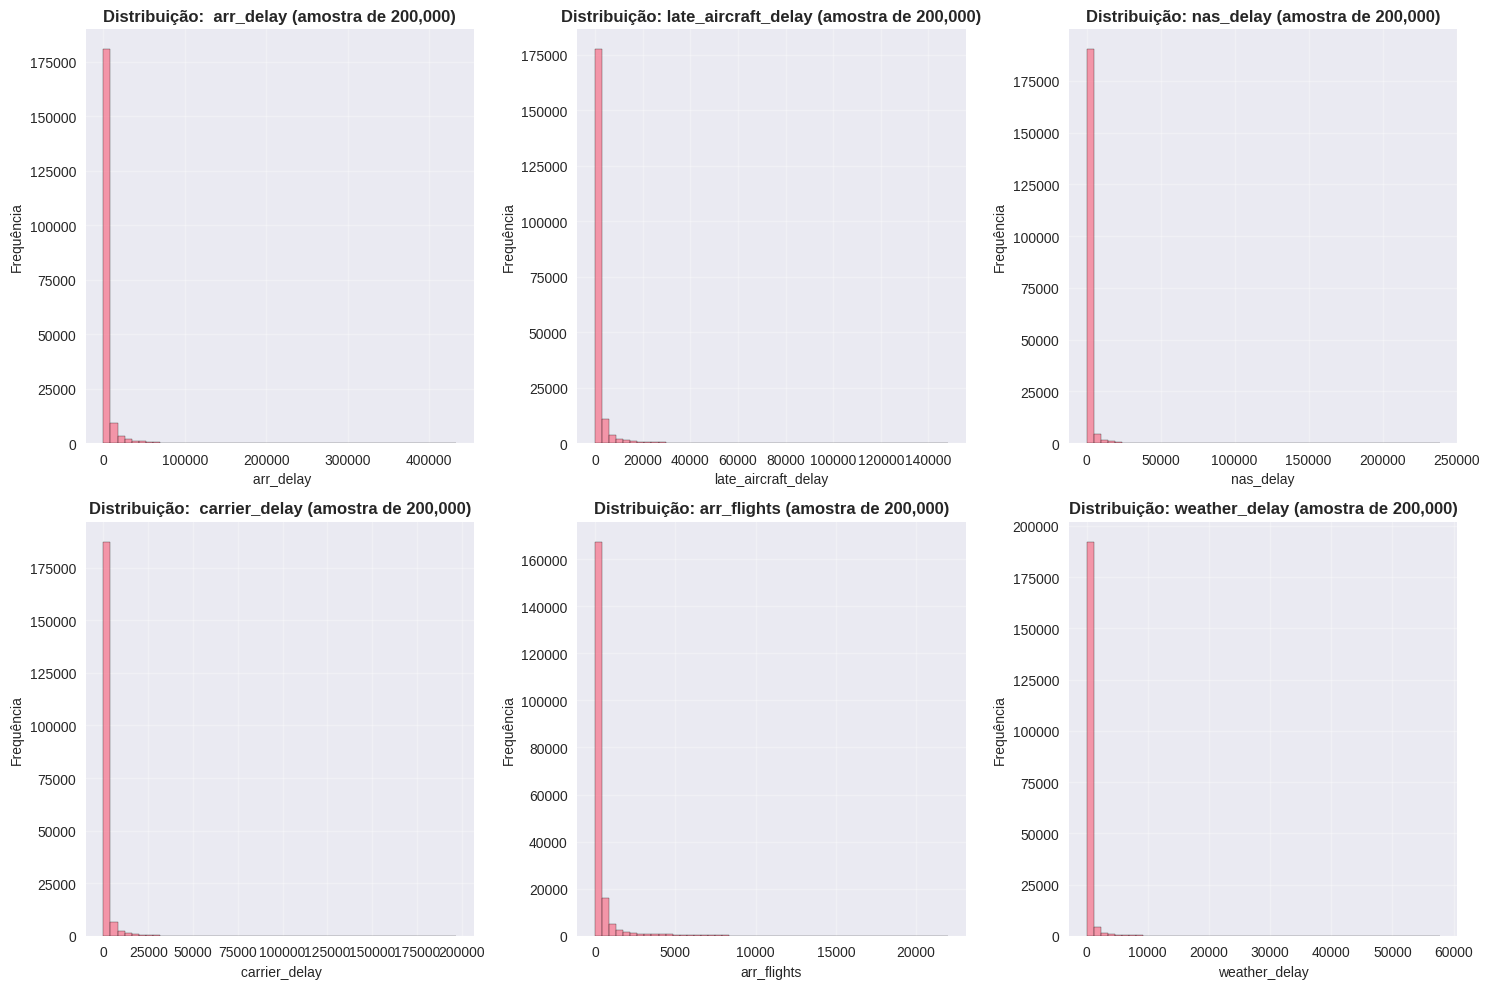

✓ Histogramas gerados para as top 6 colunas numéricas (por variância)


In [17]:
# Histogramas para as top 6 colunas numéricas (por variância)
if len(numeric_cols) > 0:
    # Selecionar top 6 por variância (mais variabilidade)
    numeric_vars = df[numeric_cols].var().sort_values(ascending=False).head(6).index.tolist()
    
    n_cols = 3
    n_rows = (len(numeric_vars) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_vars):
        ax = axes[idx]
        
        # Amostrar se necessário para performance
        sample_size = min(200000, len(df))
        if len(df) > sample_size:
            sample_df = df.sample(n=sample_size, random_state=42)
            ax.hist(sample_df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
            title_suffix = f" (amostra de {sample_size:,})"
        else:
            ax.hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
            title_suffix = ""
        
        ax.set_title(f'Distribuição: {col}{title_suffix}', fontsize=12, fontweight='bold')
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel('Frequência', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # Ocultar eixos extras
    for idx in range(len(numeric_vars), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Histogramas gerados para as top {len(numeric_vars)} colunas numéricas (por variância)")
else:
    print("Nenhuma coluna numérica disponível para histogramas.")


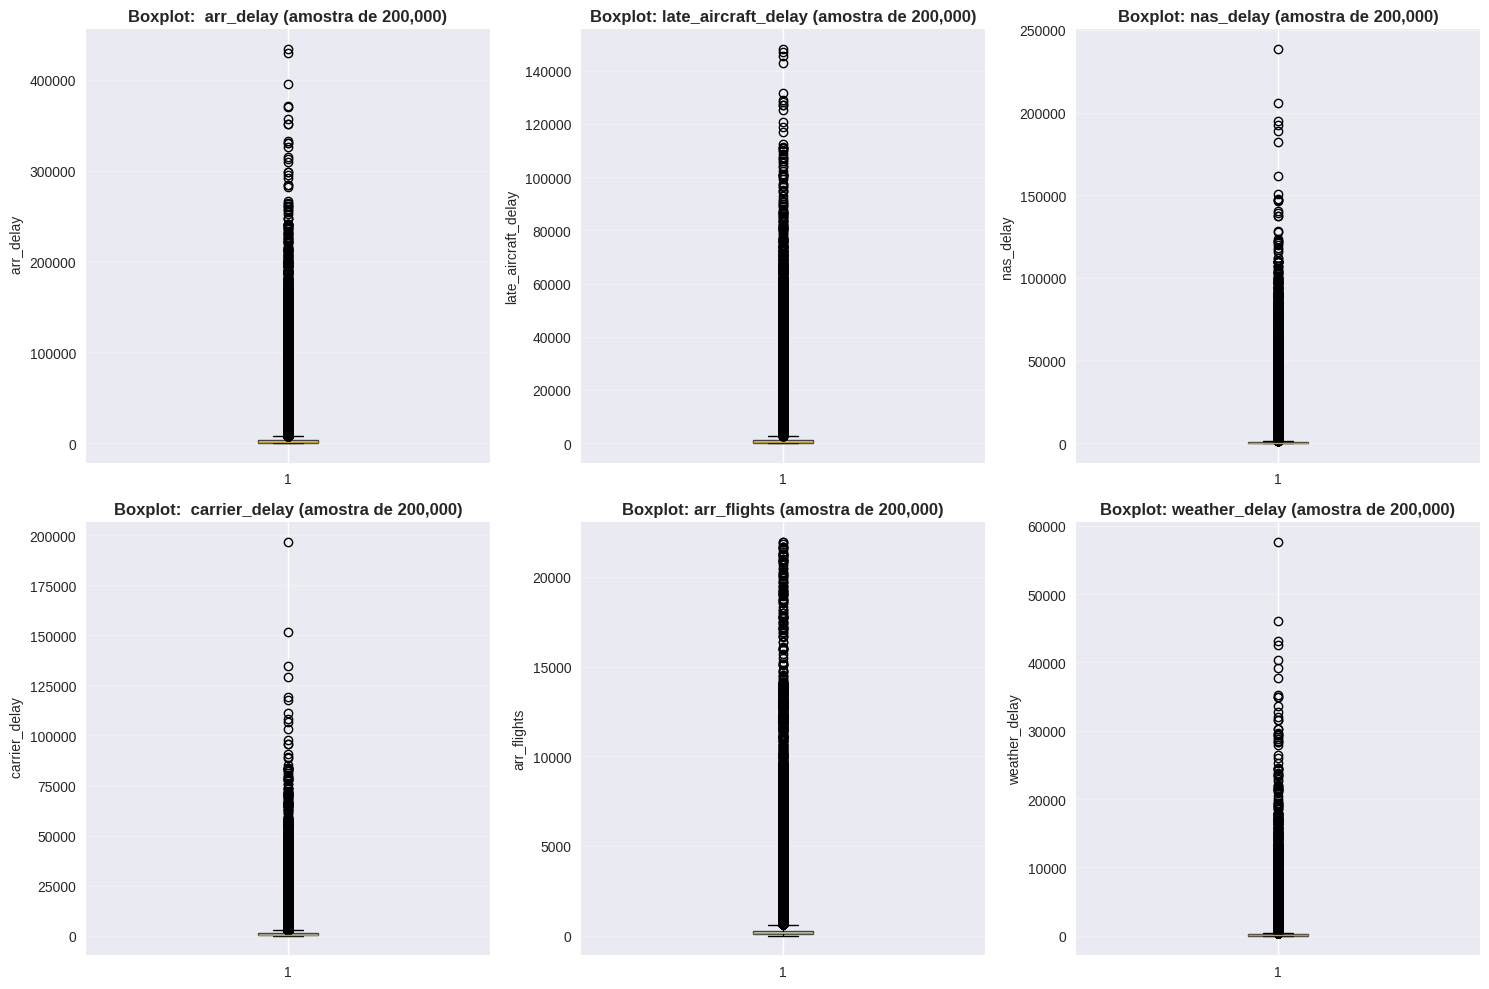

✓ Boxplots gerados para as top 6 colunas numéricas (por variância)


In [18]:
# Boxplots para as top 6 colunas numéricas
if len(numeric_cols) > 0:
    numeric_vars = df[numeric_cols].var().sort_values(ascending=False).head(6).index.tolist()
    
    n_cols = 3
    n_rows = (len(numeric_vars) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_vars):
        ax = axes[idx]
        
        # Amostrar se necessário
        sample_size = min(200000, len(df))
        if len(df) > sample_size:
            sample_df = df.sample(n=sample_size, random_state=42)
            data_to_plot = sample_df[col].dropna()
            title_suffix = f" (amostra de {sample_size:,})"
        else:
            data_to_plot = df[col].dropna()
            title_suffix = ""
        
        bp = ax.boxplot(data_to_plot, vert=True, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][0].set_alpha(0.7)
        
        ax.set_title(f'Boxplot: {col}{title_suffix}', fontsize=12, fontweight='bold')
        ax.set_ylabel(col, fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
    
    # Ocultar eixos extras
    for idx in range(len(numeric_vars), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Boxplots gerados para as top {len(numeric_vars)} colunas numéricas (por variância)")
else:
    print("Nenhuma coluna numérica disponível para boxplots.")


## Análise de Correlações

A análise de correlação nos permite identificar relações lineares entre variáveis numéricas. Um **heatmap de correlação** visualiza essas relações de forma intuitiva:

- **Valores próximos de +1**: correlação positiva forte
- **Valores próximos de -1**: correlação negativa forte
- **Valores próximos de 0**: pouca ou nenhuma correlação linear

### Principais Achados

As correlações identificadas podem indicar:
- **Multicolinearidade**: variáveis altamente correlacionadas que podem ser redundantes
- **Relações causais potenciais**: variáveis que podem influenciar outras
- **Oportunidades de agregação**: variáveis correlacionadas que podem ser combinadas


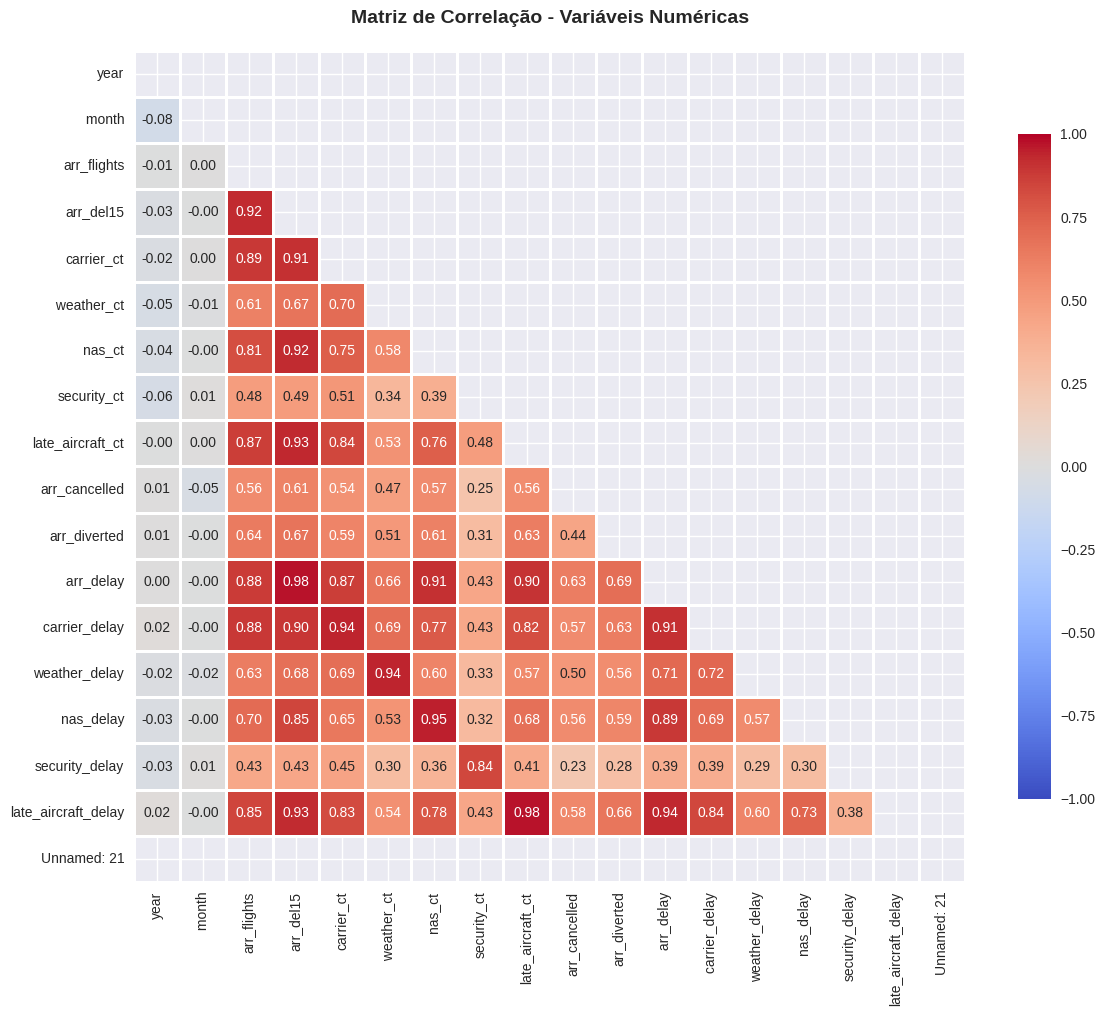

TOP 10 CORRELAÇÕES MAIS FORTES (em valor absoluto)


,Variável_1,Variável_2,Correlação,Abs_Correlação
107,late_aircraft_ct,late_aircraft_delay,0.976033,0.976033
52,arr_del15,arr_delay,0.975064,0.975064
88,nas_ct,nas_delay,0.950937,0.950937
65,carrier_ct,carrier_delay,0.943782,0.943782
77,weather_ct,weather_delay,0.939772,0.939772
125,arr_delay,late_aircraft_delay,0.937098,0.937098
49,arr_del15,late_aircraft_ct,0.930341,0.930341
57,arr_del15,late_aircraft_delay,0.925938,0.925938
47,arr_del15,nas_ct,0.924538,0.924538
31,arr_flights,arr_del15,0.923012,0.923012



✓ Heatmap de correlação gerado para 18 variáveis numéricas


In [19]:
# Matriz de correlação e heatmap
if len(numeric_cols) >= 2:
    # Calcular correlação
    corr_matrix = df[numeric_cols].corr()
    
    # Plotar heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara para mostrar apenas triângulo inferior
    
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8},
        vmin=-1,
        vmax=1
    )
    
    plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Identificar correlações mais fortes (excluindo diagonal)
    print("=" * 80)
    print("TOP 10 CORRELAÇÕES MAIS FORTES (em valor absoluto)")
    print("=" * 80)
    
    # Criar DataFrame com pares de correlação
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            if not np.isnan(corr_value):
                corr_pairs.append({
                    'Variável_1': col1,
                    'Variável_2': col2,
                    'Correlação': corr_value,
                    'Abs_Correlação': abs(corr_value)
                })
    
    if corr_pairs:
        corr_df = pd.DataFrame(corr_pairs).sort_values('Abs_Correlação', ascending=False).head(10)
        display(corr_df)
    else:
        print("Nenhuma correlação válida encontrada.")
    
    print(f"\n✓ Heatmap de correlação gerado para {len(numeric_cols)} variáveis numéricas")
else:
    print(f"Número insuficiente de variáveis numéricas ({len(numeric_cols)}) para análise de correlação. Necessário ≥ 2.")


## Análise de Variáveis Categóricas

As variáveis categóricas representam grupos ou classes nos dados. Analisamos:
- **Frequência das categorias**: quais são as mais comuns
- **Distribuição**: se há concentração em poucas categorias ou distribuição uniforme
- **Cardinalidade**: quantas categorias únicas existem

### Gráfico de Pizza

O gráfico de pizza visualiza a proporção de cada categoria. Para melhor legibilidade, agrupamos categorias menos frequentes em "Outros" quando há muitas categorias.


In [20]:
# Análise de variáveis categóricas
if len(categorical_cols) > 0:
    print("=" * 80)
    print("ANÁLISE DE VARIÁVEIS CATEGÓRICAS")
    print("=" * 80)
    
    # Encontrar a coluna categórica mais relevante (maior frequência/top categorias)
    # Critério: coluna com maior número de valores não nulos e boa distribuição
    cat_analysis = []
    for col in categorical_cols:
        non_null_count = df[col].notna().sum()
        unique_count = df[col].nunique()
        if non_null_count > 0:
            # Calcular entropia como medida de distribuição (maior = mais distribuído)
            value_counts = df[col].value_counts()
            proportions = value_counts / value_counts.sum()
            entropy = -(proportions * np.log2(proportions + 1e-10)).sum()
            cat_analysis.append({
                'Coluna': col,
                'Valores_Não_Nulos': non_null_count,
                'Categorias_Únicas': unique_count,
                'Entropia': entropy
            })
    
    if cat_analysis:
        cat_df = pd.DataFrame(cat_analysis).sort_values('Valores_Não_Nulos', ascending=False)
        display(cat_df)
        
        # Selecionar a coluna mais relevante (maior não nulos, boa entropia)
        best_cat_col = cat_df.iloc[0]['Coluna']
        print(f"\n✓ Coluna categórica selecionada para análise detalhada: {best_cat_col}")
    else:
        best_cat_col = None
        print("Nenhuma coluna categórica válida encontrada.")
else:
    best_cat_col = None
    print("Nenhuma coluna categórica encontrada no dataset.")


ANÁLISE DE VARIÁVEIS CATEGÓRICAS


,Coluna,Valores_Não_Nulos,Categorias_Únicas,Entropia
0,carrier,279182,28,4.323259
1,carrier_name,279182,32,4.447327
2,airport,279182,409,7.781574
3,airport_name,279182,409,7.781574



✓ Coluna categórica selecionada para análise detalhada: carrier


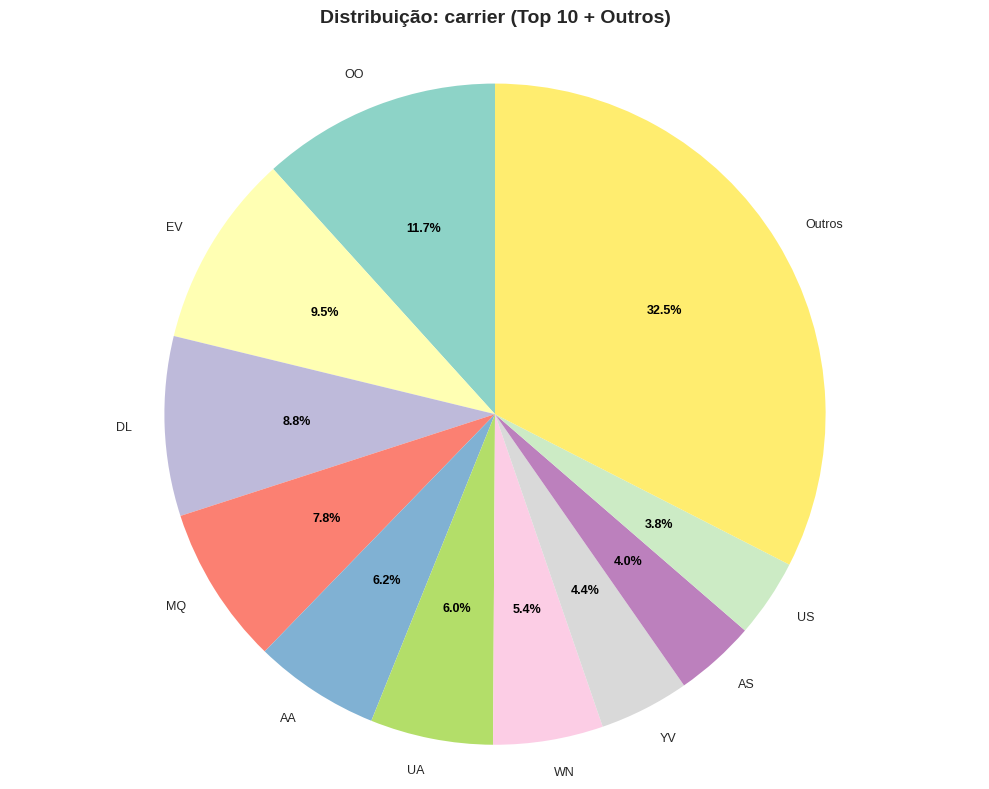

FREQUÊNCIA DAS CATEGORIAS: carrier


,Categoria,Frequência,Percentual
0,OO,32678,11.70
1,EV,26508,9.49
2,DL,24511,8.78
3,MQ,21661,7.76
4,AA,17200,6.16
5,UA,16772,6.01
6,WN,15009,5.38
7,YV,12297,4.40
8,AS,11057,3.96
9,US,10698,3.83



✓ Gráfico de pizza gerado para: carrier


In [21]:
# Gráfico de pizza para a coluna categórica mais relevante
if best_cat_col is not None:
    value_counts = df[best_cat_col].value_counts()
    
    # Agrupar categorias menos frequentes em "Outros" (top 10)
    top_n = 10
    if len(value_counts) > top_n:
        top_categories = value_counts.head(top_n)
        others_count = value_counts.iloc[top_n:].sum()
        plot_data = top_categories.copy()
        plot_data['Outros'] = others_count
        plot_title = f'Distribuição: {best_cat_col} (Top {top_n} + Outros)'
    else:
        plot_data = value_counts
        plot_title = f'Distribuição: {best_cat_col}'
    
    # Criar gráfico de pizza
    plt.figure(figsize=(10, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
    wedges, texts, autotexts = plt.pie(
        plot_data.values,
        labels=plot_data.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 9}
    )
    
    # Melhorar legibilidade
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    
    plt.title(plot_title, fontsize=14, fontweight='bold', pad=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # Tabela com frequências
    print("=" * 80)
    print(f"FREQUÊNCIA DAS CATEGORIAS: {best_cat_col}")
    print("=" * 80)
    freq_table = pd.DataFrame({
        'Categoria': plot_data.index,
        'Frequência': plot_data.values,
        'Percentual': (plot_data.values / plot_data.values.sum() * 100).round(2)
    })
    display(freq_table)
    
    print(f"\n✓ Gráfico de pizza gerado para: {best_cat_col}")
else:
    print("Nenhuma coluna categórica disponível para gráfico de pizza.")


## Regressão Linear Exploratória

Realizamos uma **regressão linear simples** para explorar relações entre variáveis numéricas. A escolha das variáveis é automática:

- **Variável dependente (y)**: coluna numérica com maior variância (mais variabilidade)
- **Variável independente (x)**: coluna numérica com maior correlação absoluta com y

### Interpretação

- **R² (R-quadrado)**: proporção da variância de y explicada por x (0 a 1, quanto maior melhor)
- **Coeficiente angular**: mudança esperada em y para cada unidade de mudança em x
- **Coeficiente linear**: valor esperado de y quando x = 0

**Nota**: Esta é uma análise exploratória. Para análises preditivas robustas, seria necessário validar pressupostos (linearidade, homocedasticidade, normalidade dos resíduos).


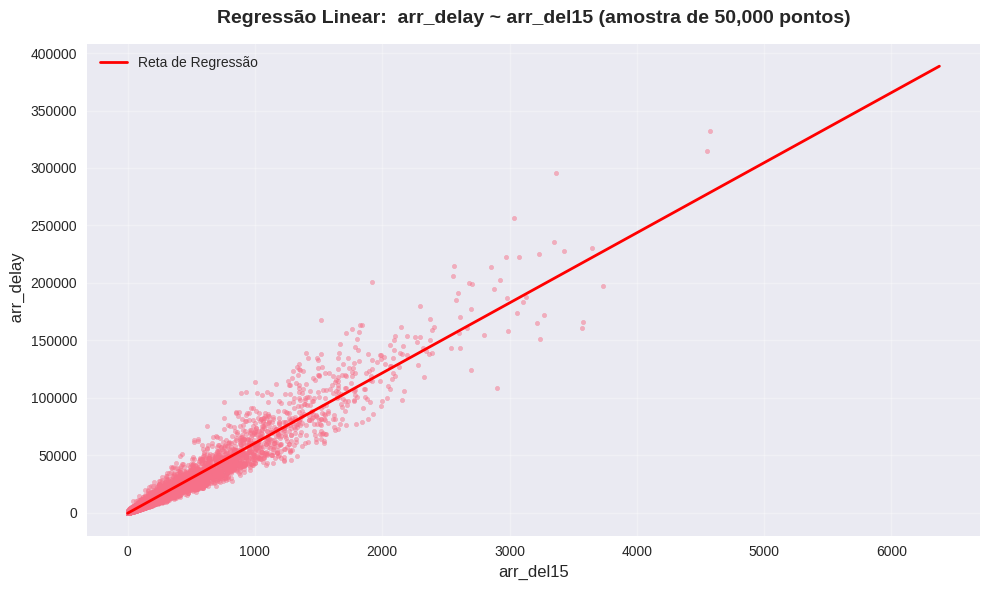

RESULTADOS DA REGRESSÃO LINEAR
Variável dependente (y):  arr_delay
Variável independente (x): arr_del15

Coeficientes:
  Intercepto (β₀): -286.6647
  Coeficiente angular (β₁): 60.9763

Métricas:
  R² (R-quadrado): 0.9508
  Interpretação R²: 95.08% da variância de ' arr_delay' é explicada por 'arr_del15'

Equação:  arr_delay = -286.6647 + 60.9763 × arr_del15


In [22]:
# Regressão linear exploratória
if len(numeric_cols) >= 2:
    # Escolher y: coluna numérica com maior variância
    variances = df[numeric_cols].var()
    y_col = variances.idxmax()
    
    # Escolher x: coluna numérica com maior correlação absoluta com y (excluindo y)
    remaining_cols = [c for c in numeric_cols if c != y_col]
    if remaining_cols:
        correlations = df[remaining_cols].corrwith(df[y_col]).abs()
        x_col = correlations.idxmax()
        
        # Preparar dados (remover nulos)
        regression_df = df[[x_col, y_col]].dropna()
        
        if len(regression_df) > 0:
            X = regression_df[x_col].values
            y = regression_df[y_col].values
            
            # Ajustar modelo
            if USE_STATSMODELS:
                X_with_const = sm.add_constant(X)
                model = OLS(y, X_with_const).fit()
                r_squared = model.rsquared
                intercept = model.params[0]
                slope = model.params[1]
                predictions = model.predict(X_with_const)
            else:
                X_reshaped = X.reshape(-1, 1)
                model = LinearRegression()
                model.fit(X_reshaped, y)
                predictions = model.predict(X_reshaped)
                r_squared = model.score(X_reshaped, y)
                intercept = model.intercept_
                slope = model.coef_[0]
            
            # Plotar scatter + reta de regressão
            plt.figure(figsize=(10, 6))
            
            # Amostrar se necessário para performance
            sample_size = min(50000, len(regression_df))
            if len(regression_df) > sample_size:
                sample_idx = np.random.choice(len(regression_df), sample_size, replace=False)
                plt.scatter(X[sample_idx], y[sample_idx], alpha=0.5, s=10)
                title_suffix = f" (amostra de {sample_size:,} pontos)"
            else:
                plt.scatter(X, y, alpha=0.5, s=10)
                title_suffix = ""
            
            # Plotar reta de regressão
            X_sorted = np.sort(X)
            if USE_STATSMODELS:
                X_sorted_const = sm.add_constant(X_sorted)
                y_pred_sorted = model.predict(X_sorted_const)
            else:
                y_pred_sorted = model.predict(X_sorted.reshape(-1, 1))
            
            plt.plot(X_sorted, y_pred_sorted, 'r-', linewidth=2, label='Reta de Regressão')
            
            plt.xlabel(x_col, fontsize=12)
            plt.ylabel(y_col, fontsize=12)
            plt.title(f'Regressão Linear: {y_col} ~ {x_col}{title_suffix}', 
                      fontsize=14, fontweight='bold', pad=15)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Imprimir resultados
            print("=" * 80)
            print("RESULTADOS DA REGRESSÃO LINEAR")
            print("=" * 80)
            print(f"Variável dependente (y): {y_col}")
            print(f"Variável independente (x): {x_col}")
            print(f"\nCoeficientes:")
            print(f"  Intercepto (β₀): {intercept:.4f}")
            print(f"  Coeficiente angular (β₁): {slope:.4f}")
            print(f"\nMétricas:")
            print(f"  R² (R-quadrado): {r_squared:.4f}")
            print(f"  Interpretação R²: {r_squared*100:.2f}% da variância de '{y_col}' é explicada por '{x_col}'")
            print(f"\nEquação: {y_col} = {intercept:.4f} + {slope:.4f} × {x_col}")
            
        else:
            print(f"Não há dados suficientes (sem nulos) para regressão entre {x_col} e {y_col}.")
    else:
        print("Número insuficiente de variáveis numéricas para regressão.")
else:
    print("Número insuficiente de variáveis numéricas (< 2) para regressão linear.")


## Detecção de Outliers via IQR

Outliers são valores que se desviam significativamente do padrão dos dados. Utilizamos o método **IQR (Intervalo Interquartil)** para detectá-los:

### Método IQR

1. Calcular Q1 (25º percentil) e Q3 (75º percentil)
2. Calcular IQR = Q3 - Q1
3. Definir limites:
   - **Limite inferior**: Q1 - 1.5 × IQR
   - **Limite superior**: Q3 + 1.5 × IQR
4. Valores fora desses limites são considerados outliers

### Impacto dos Outliers

Outliers podem indicar:
- **Erros de medição ou entrada de dados**
- **Casos legítimos mas raros** (ex: eventos extremos)
- **Necessidade de tratamento** nas próximas camadas (Silver/Gold)

**Decisão sobre tratamento**: deve ser feita com conhecimento de domínio. Nem todos os outliers devem ser removidos.


In [23]:
# Função para detectar outliers via IQR
def iqr_outliers(series, multiplier=1.5):
    """
    Detecta outliers usando o método IQR.
    
    Parameters:
    -----------
    series : pd.Series
        Série numérica
    multiplier : float
        Multiplicador do IQR (padrão: 1.5)
    
    Returns:
    --------
    tuple: (outliers_series, lower_bound, upper_bound, q1, q3, iqr)
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    
    outliers = (series < lower_bound) | (series > upper_bound)
    
    return outliers, lower_bound, upper_bound, q1, q3, iqr

print("Função iqr_outliers() definida com sucesso!")


Função iqr_outliers() definida com sucesso!


In [24]:
# Detecção de outliers para colunas numéricas principais
if len(numeric_cols) > 0:
    # Selecionar top 6 colunas numéricas por variância
    top_numeric = df[numeric_cols].var().sort_values(ascending=False).head(6).index.tolist()
    
    outliers_summary_list = []
    
    print("=" * 80)
    print("DETECÇÃO DE OUTLIERS VIA IQR (1.5 × IQR)")
    print("=" * 80)
    
    for col in top_numeric:
        series = df[col].dropna()
        if len(series) > 0:
            outliers_mask, lower_bound, upper_bound, q1, q3, iqr = iqr_outliers(series)
            outliers_count = outliers_mask.sum()
            outliers_pct = (outliers_count / len(series) * 100)
            
            outliers_summary_list.append({
                'Coluna': col,
                'Total_Valores': len(series),
                'Q1': q1,
                'Q3': q3,
                'IQR': iqr,
                'Limite_Inferior': lower_bound,
                'Limite_Superior': upper_bound,
                'Outliers_Count': outliers_count,
                'Outliers_Percentual': outliers_pct
            })
            
            print(f"\n{col}:")
            print(f"  Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}")
            print(f"  Limites: [{lower_bound:.2f}, {upper_bound:.2f}]")
            print(f"  Outliers: {outliers_count:,} ({outliers_pct:.2f}%)")
    
    # Criar DataFrame resumo
    outliers_summary_df = pd.DataFrame(outliers_summary_list)
    display(outliers_summary_df)
    
    # Salvar artefato
    outliers_summary_df.to_csv(artifacts_dir / "outliers_summary.csv", index=False)
    print(f"\n✓ Artefato salvo: {artifacts_dir / 'outliers_summary.csv'}")
else:
    print("Nenhuma coluna numérica disponível para detecção de outliers.")


DETECÇÃO DE OUTLIERS VIA IQR (1.5 × IQR)

 arr_delay:
  Q1: 506.00, Q3: 3261.00, IQR: 2755.00
  Limites: [-3626.50, 7393.50]
  Outliers: 30,950 (11.10%)

late_aircraft_delay:
  Q1: 101.00, Q3: 1200.00, IQR: 1099.00
  Limites: [-1547.50, 2848.50]
  Outliers: 32,064 (11.50%)

nas_delay:
  Q1: 70.00, Q3: 656.00, IQR: 586.00
  Limites: [-809.00, 1535.00]
  Outliers: 34,116 (12.24%)

 carrier_delay:
  Q1: 170.00, Q3: 1138.00, IQR: 968.00
  Limites: [-1282.00, 2590.00]
  Outliers: 27,674 (9.93%)

arr_flights:
  Q1: 61.00, Q3: 284.00, IQR: 223.00
  Limites: [-273.50, 618.50]
  Outliers: 31,045 (11.13%)

weather_delay:
  Q1: 0.00, Q3: 169.00, IQR: 169.00
  Limites: [-253.50, 422.50]
  Outliers: 33,215 (11.91%)


,Coluna,Total_Valores,Q1,Q3,IQR,Limite_Inferior,Limite_Superior,Outliers_Count,Outliers_Percentual
0,arr_delay,278806,506.0,3261.0,2755.0,-3626.5,7393.5,30950,11.100909
1,late_aircraft_delay,278806,101.0,1200.0,1099.0,-1547.5,2848.5,32064,11.500470
2,nas_delay,278806,70.0,656.0,586.0,-809.0,1535.0,34116,12.236465
3,carrier_delay,278806,170.0,1138.0,968.0,-1282.0,2590.0,27674,9.925898
4,arr_flights,278806,61.0,284.0,223.0,-273.5,618.5,31045,11.134983
5,weather_delay,278806,0.0,169.0,169.0,-253.5,422.5,33215,11.913302



✓ Artefato salvo: eda_artifacts/outliers_summary.csv


In [25]:
# Top 10 valores outliers por coluna
if len(numeric_cols) > 0:
    top_numeric = df[numeric_cols].var().sort_values(ascending=False).head(6).index.tolist()
    
    print("=" * 80)
    print("TOP 10 VALORES OUTLIERS POR COLUNA")
    print("=" * 80)
    
    for col in top_numeric:
        series = df[col].dropna()
        if len(series) > 0:
            outliers_mask, _, _, _, _, _ = iqr_outliers(series)
            outliers_series = series[outliers_mask]
            
            if len(outliers_series) > 0:
                # Top 10 por valor absoluto
                top_outliers = outliers_series.abs().nlargest(10)
                top_outliers_df = pd.DataFrame({
                    'Índice': top_outliers.index,
                    'Valor': series.loc[top_outliers.index],
                    'Valor_Absoluto': top_outliers.values
                }).sort_values('Valor_Absoluto', ascending=False)
                
                print(f"\n{col} - Top 10 Outliers:")
                display(top_outliers_df[['Índice', 'Valor']].head(10))
            else:
                print(f"\n{col}: Nenhum outlier encontrado.")


TOP 10 VALORES OUTLIERS POR COLUNA

 arr_delay - Top 10 Outliers:


,Índice,Valor
155004,155004,433687.0
56975,56975,429194.0
266796,266796,395609.0
204744,204744,370937.0
188554,188554,369537.0
163364,163364,356883.0
6828,6828,350989.0
218296,218296,350661.0
149324,149324,332144.0
227236,227236,330429.0



late_aircraft_delay - Top 10 Outliers:


,Índice,Valor
45969,45969,148181.0
56975,56975,147167.0
170841,170841,145680.0
163364,163364,142872.0
163991,163991,134763.0
204744,204744,131666.0
266796,266796,129200.0
17680,17680,128076.0
187004,187004,127300.0
238618,238618,127057.0



nas_delay - Top 10 Outliers:


,Índice,Valor
155004,155004,238440.0
218296,218296,205865.0
1320,1320,199891.0
149324,149324,194725.0
6828,6828,192593.0
863,863,188994.0
6366,6366,182102.0
216215,216215,175457.0
3620,3620,161381.0
82180,82180,151464.0



 carrier_delay - Top 10 Outliers:


,Índice,Valor
266796,266796,196944.0
56975,56975,151581.0
228868,228868,134693.0
230505,230505,129148.0
227236,227236,119165.0
232138,232138,117535.0
235381,235381,111972.0
258379,258379,110997.0
204744,204744,108068.0
188554,188554,106746.0



arr_flights - Top 10 Outliers:


,Índice,Valor
266796,266796,21977.0
270619,270619,21931.0
141018,141018,21873.0
139265,139265,21839.0
206467,206467,21688.0
265767,265767,21681.0
192342,192342,21648.0
263723,263723,21623.0
191258,191258,21589.0
129543,129543,21550.0



weather_delay - Top 10 Outliers:


,Índice,Valor
227236,227236,57707.0
96993,96993,56006.0
163708,163708,50610.0
84121,84121,46014.0
228868,228868,43115.0
22214,22214,42491.0
235381,235381,42417.0
85529,85529,40287.0
20610,20610,39115.0
5991,5991,37713.0


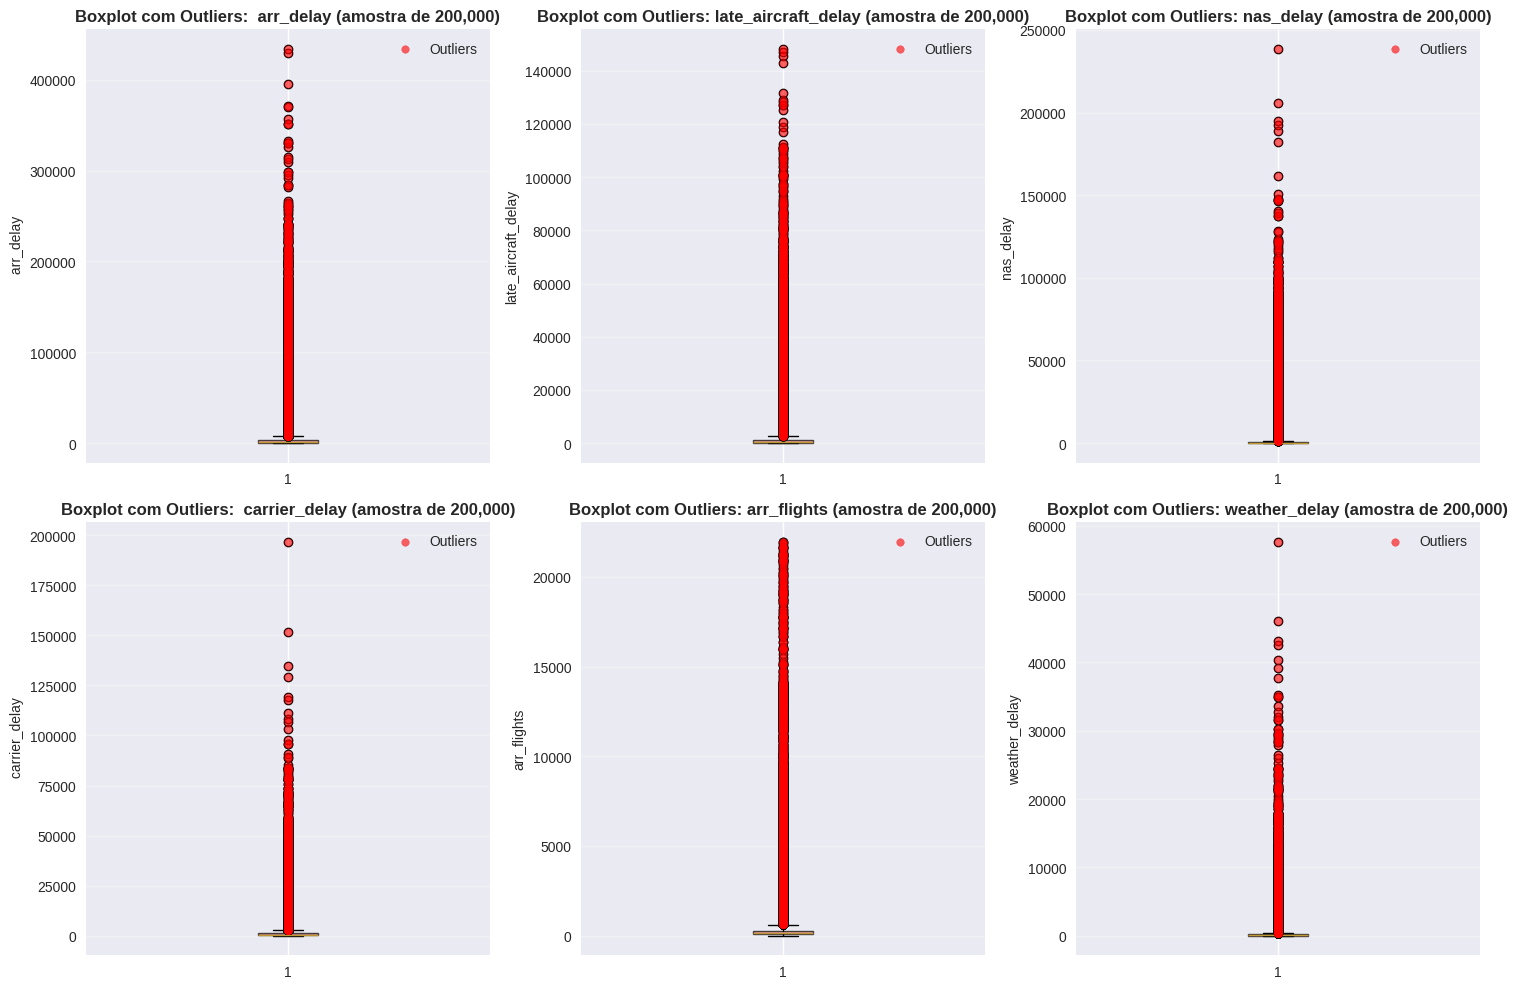

✓ Boxplots com outliers destacados gerados para 6 colunas


In [26]:
# Boxplots destacando outliers
if len(numeric_cols) > 0:
    top_numeric = df[numeric_cols].var().sort_values(ascending=False).head(6).index.tolist()
    
    n_cols = 3
    n_rows = (len(top_numeric) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(top_numeric):
        ax = axes[idx]
        
        # Amostrar se necessário
        sample_size = min(200000, len(df))
        if len(df) > sample_size:
            sample_df = df.sample(n=sample_size, random_state=42)
            data_to_plot = sample_df[col].dropna()
            title_suffix = f" (amostra de {sample_size:,})"
        else:
            data_to_plot = df[col].dropna()
            title_suffix = ""
        
        # Boxplot
        bp = ax.boxplot(data_to_plot, vert=True, patch_artist=True, showfliers=True)
        bp['boxes'][0].set_facecolor('lightcoral')
        bp['boxes'][0].set_alpha(0.7)
        
        # Destacar outliers manualmente (opcional - já são mostrados por padrão)
        outliers_mask, lower_bound, upper_bound, _, _, _ = iqr_outliers(data_to_plot)
        outliers_values = data_to_plot[outliers_mask]
        
        if len(outliers_values) > 0:
            # Plotar outliers destacados
            outlier_indices = np.where(outliers_mask)[0]
            ax.scatter([1] * len(outlier_indices), outliers_values.values, 
                      color='red', s=30, alpha=0.6, zorder=3, label='Outliers')
        
        ax.set_title(f'Boxplot com Outliers: {col}{title_suffix}', 
                    fontsize=12, fontweight='bold')
        ax.set_ylabel(col, fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        if len(outliers_values) > 0:
            ax.legend()
    
    # Ocultar eixos extras
    for idx in range(len(top_numeric), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Boxplots com outliers destacados gerados para {len(top_numeric)} colunas")
else:
    print("Nenhuma coluna numérica disponível para boxplots de outliers.")


## Insights e Hipóteses

### Principais Achados

Com base na análise exploratória realizada, identificamos os seguintes pontos principais:

1. **Qualidade dos Dados**:
   - Percentual de valores nulos por coluna
   - Presença de linhas duplicadas
   - Cardinalidade das variáveis

2. **Distribuições**:
   - Assimetria e forma das distribuições numéricas
   - Concentração de categorias nas variáveis categóricas

3. **Relações**:
   - Correlações entre variáveis numéricas
   - Relação linear explorada via regressão

4. **Anomalias**:
   - Outliers detectados via IQR
   - Valores extremos que podem precisar de tratamento

### Limitações Identificadas

- **Dados faltantes**: podem impactar análises futuras e precisam ser tratados
- **Granularidade**: pode ser necessário agregar dados para análises específicas
- **Viés potencial**: amostragem ou coleta podem ter vieses não identificados nesta etapa
- **Temporalidade**: se houver dimensão temporal, pode haver sazonalidade não explorada aqui
- **Outliers**: podem ser erros ou casos legítimos - requer conhecimento de domínio para decisão

### Hipóteses para Validação

Com base nos padrões observados, algumas hipóteses que podem ser validadas nas próximas camadas:

- Relações causais entre variáveis correlacionadas
- Impacto de outliers em análises agregadas
- Necessidade de normalização/transformação de variáveis
- Oportunidades de engenharia de features


## Perguntas para as Próximas Camadas (Silver/Gold)

Esta seção apresenta perguntas analíticas que podem ser respondidas através de consultas SQL e visualizações no Power BI após a construção da camada Silver/Gold (Data Warehouse). Essas perguntas orientam o design do modelo dimensional e das tabelas de fato/dimensão.

### Perguntas Analíticas

1. **Qual é a tendência temporal dos principais indicadores?**
   - Como os valores evoluem ao longo do tempo?
   - Existem padrões sazonais ou ciclos?
   - SQL: agregações por período (dia, mês, trimestre, ano)
   - Visualização: séries temporais, gráficos de linha

2. **Quais são as principais categorias/segmentos e suas contribuições?**
   - Quais categorias representam a maior proporção?
   - Como as categorias se distribuem geograficamente ou por outro critério?
   - SQL: GROUP BY com contagens e percentuais
   - Visualização: gráficos de pizza, barras, treemap

3. **Quais são as correlações mais fortes entre variáveis de negócio?**
   - Quais variáveis influenciam mais os resultados?
   - Existem relações não lineares?
   - SQL: cálculos de correlação, JOINs para combinar dimensões
   - Visualização: heatmaps, scatter plots, matriz de correlação

4. **Como os outliers impactam as métricas agregadas?**
   - Qual a diferença nas métricas com e sem outliers?
   - Outliers são concentrados em algum segmento?
   - SQL: filtros WHERE, CASE WHEN para categorizar outliers
   - Visualização: boxplots comparativos, tabelas side-by-side

5. **Quais são os top N e bottom N por diferentes dimensões?**
   - Quais são os melhores/piores desempenhos?
   - Rankings por categoria, período, região, etc.
   - SQL: ROW_NUMBER(), RANK(), TOP N queries
   - Visualização: gráficos de barras horizontais, tabelas ranqueadas

6. **Qual é a distribuição de valores por faixas/quartis?**
   - Como os dados se distribuem em faixas?
   - Quais faixas concentram mais observações?
   - SQL: CASE WHEN para criar faixas, cálculos de quartis
   - Visualização: histogramas, gráficos de barras, distribuições

7. **Existem padrões de agrupamento ou segmentação natural?**
   - Os dados formam clusters naturais?
   - Quais características definem cada grupo?
   - SQL: agregações com múltiplas dimensões, cálculos de médias/medianas por grupo
   - Visualização: scatter plots coloridos, gráficos de radar, análise de clusters

8. **Qual é o impacto de variáveis categóricas nas métricas numéricas?**
   - Como diferentes categorias afetam os resultados?
   - Existem interações entre categorias?
   - SQL: JOINs entre fato e dimensões, agregações por categoria
   - Visualização: gráficos de barras agrupadas, boxplots por categoria, violin plots

9. **Quais são as métricas de crescimento, variação percentual e tendências?**
   - Crescimento período a período (MoM, YoY)
   - Variações percentuais e taxas de mudança
   - SQL: LAG(), window functions, cálculos de variação percentual
   - Visualização: gráficos de linha com anotações, indicadores KPI, sparklines

10. **Como os dados se comportam em diferentes granularidades temporais?**
    - Comparação entre diferentes períodos (diário vs. mensal vs. anual)
    - Agregações em múltiplos níveis hierárquicos
    - SQL: GROUP BY com diferentes granularidades, CTEs para múltiplas agregações
    - Visualização: dashboards com drill-down, gráficos hierárquicos

11. **Quais são as métricas de qualidade de dados por dimensão?**
    - Taxa de completude por categoria, período, região
    - Identificação de dimensões com maior qualidade
    - SQL: contagens de nulos, cálculos de percentual de completude
    - Visualização: heatmaps de qualidade, indicadores de completude, alertas

12. **Existem relações de causa e efeito que podem ser exploradas?**
    - Análise de precedência temporal
    - Identificação de variáveis preditoras
    - SQL: JOINs temporais, window functions com LAG/LEAD
    - Visualização: gráficos de correlação temporal, análise de causalidade

### Considerações para o Design do DW

- **Tabelas de Fato**: devem incluir métricas numéricas identificadas como relevantes
- **Tabelas de Dimensão**: devem incluir categorias e atributos descritivos
- **Granularidade**: definir a granularidade mínima (ex: transacional, diária, mensal)
- **Agregações Pré-calculadas**: considerar tabelas de agregação para performance
- **Índices**: criar índices em chaves de dimensão e campos temporais
- **Particionamento**: considerar particionamento por data se houver dimensão temporal


---

## Conclusão

Este notebook realizou uma **análise exploratória completa** dos dados brutos na camada Raw/Bronze. Os principais entregáveis foram:

✅ **Análise de qualidade**: identificação de nulos, duplicados e cardinalidade  
✅ **Estatísticas descritivas**: compreensão das distribuições e métricas básicas  
✅ **Análise visual**: histogramas, boxplots, correlações e gráficos categóricos  
✅ **Detecção de outliers**: identificação via IQR com exemplos e visualizações  
✅ **Modelagem exploratória**: regressão linear para identificar relações  
✅ **Artefatos gerados**: CSVs com resumos de nulos e outliers  
✅ **Perguntas analíticas**: 12 perguntas para orientar o design da camada Silver/Gold  

### Próximos Passos

1. **Camada Silver**: aplicar transformações, limpezas e normalizações baseadas nos achados
2. **Camada Gold**: criar modelo dimensional (star/snowflake schema) para análises de negócio
3. **Visualizações**: desenvolver dashboards no Power BI baseados nas perguntas analíticas
4. **Validação**: validar hipóteses e relações identificadas com conhecimento de domínio

---

**Notebook gerado automaticamente para análise exploratória de dados brutos.**
